# Introduction

This is the introduction.

In [1]:
%matplotlib inline
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
from astropy import time

from jplephem.spk import SPK

from poliastro import iod
from poliastro.bodies import Sun
from poliastro.twobody import State

In [2]:
kernel = SPK.open('../poliastro/ephem/de421.bsp')

In [3]:
# Initial data
N = 50

date_launch = time.Time('2011-11-26 15:02', scale='utc')
date_arrival = time.Time('2012-08-06 05:17', scale='utc')
tof = (date_arrival - date_launch)

tof.to(u.h)

<Quantity 6086.250277777778 h>

In [4]:
# Calculate Julian days vector
jd_launch = date_launch.jd
jd_arrival = date_arrival.jd
jd_vec = np.linspace(jd_launch, jd_arrival, num=N)

In [5]:
rr_earth = (kernel[0, 3].compute(jd_vec) +
            kernel[3, 399].compute(jd_vec) -
            kernel[0, 10].compute(jd_vec))
rr_earth[:, 0] * u.km

<Quantity [  6.51091747e+07,  1.21583711e+08,  5.27085881e+07] km>

In [6]:
vv_earth = (kernel[0, 3].compute_and_differentiate(jd_vec)[1] +
            kernel[3, 399].compute_and_differentiate(jd_vec)[1] -
            kernel[0, 10].compute_and_differentiate(jd_vec)[1])
vv_earth[:, 0] * u.km / u.s

<Quantity [-2352988.89039678, 1032712.13725378,  447592.34074703] km / s>

In [7]:
rr_mars = (kernel[0, 4].compute(jd_vec)-
           kernel[0, 10].compute(jd_vec))
rr_mars[:, 0] * u.km

<Quantity [ -1.22641576e+08,  1.90912768e+08,  9.08787866e+07] km>

In [8]:
vv_mars = (kernel[0, 4].compute_and_differentiate(jd_vec)[1]-
           kernel[0, 10].compute_and_differentiate(jd_vec)[1])
vv_mars[:, 0] * u.km / u.s

<Quantity [-1731223.03553389, -810390.09922685, -324947.74414389] km / s>

In [9]:
# Compute the transfer orbit!
r0 = rr_earth[:, 0]
rf = rr_mars[:, -1]

va, vb = iod.lambert(Sun.k.to(u.km**3 / u.s**2).value,
                     r0,
                     rf,
                     tof.to(u.s).value)

ss0_trans = State.from_vectors(Sun, r0 * u.km, va * u.km / u.s, date_launch)
ssf_trans = State.from_vectors(Sun, rf * u.km, vb * u.km / u.s, date_arrival)

In [10]:
# Extract whole orbit of Earth, Mars and transfer (for plotting)
rr_trans = np.zeros_like(rr_earth)
rr_trans[:, 0] = r0
for ii in range(1, len(jd_vec)):
    tof = (jd_vec[ii] - jd_vec[0]) * u.day
    rr_trans[:, ii] = ss0_trans.propagate(tof).r

# Better compute backwards
rr_earth_rest = 1
rr_mars_rest = 1

<div class="alert alert-warning">The positions are in the <strong>International Standard Reference Frame</strong>, which has the Equator as the fundamental plane! astropy still doesn't have support for ecliptic coordinates, see https://github.com/astropy/astropy/issues/1430</div>

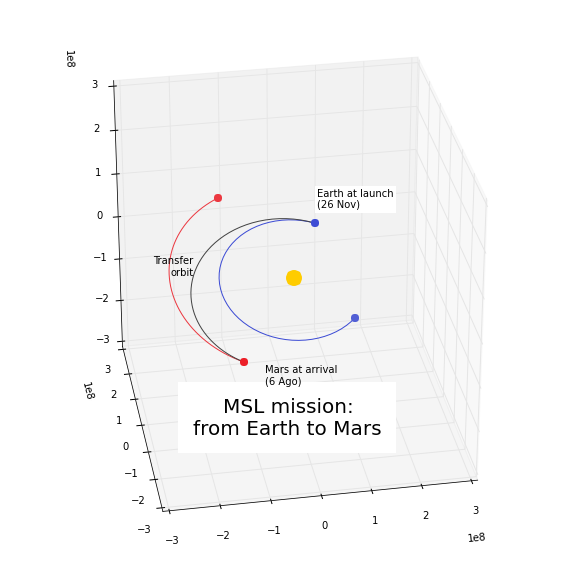

In [11]:
# Plot figure
# To add arrows:
# https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/streamplot.py#L140
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

def plot_body(ax, r, color, size, border=False, **kwargs):
    """Plots body in axes object.

    """
    return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

# I like color
color_earth0 = '#3d4cd5'
color_earthf = '#525fd5'
color_mars0 = '#ec3941'
color_marsf = '#ec1f28'
color_sun = '#ffcc00'
color_orbit = '#888888'
color_trans = '#444444'

# Plotting orbits is easy!
ax.plot(*rr_earth, c=color_earth0)
ax.plot(*rr_mars, c=color_mars0)
ax.plot(*rr_trans, c=color_trans)

#ax.plot(*rr_earth_rest.T, ls='--', c=color_orbit)
#ax.plot(*rr_mars_rest.T, ls='--', c=color_orbit)

# But plotting planets feels even magical!
plot_body(ax, np.zeros(3), color_sun, 16)

plot_body(ax, r0, color_earth0, 8)
plot_body(ax, rr_earth[:, -1], color_earthf, 8)

plot_body(ax, rr_mars[:, 0], color_mars0, 8)
plot_body(ax, rf, color_marsf, 8)

# Add some text
ax.text(-0.75e8, -3.5e8, -1e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
ax.text(r0[0] * 1.15, r0[1] * 1.25, r0[2] * 1.25, "Earth at launch\n(26 Nov)", ha="left", va="bottom", backgroundcolor='#ffffff')
ax.text(rf[0] * 0.7, rf[1] * 1.1, rf[2], "Mars at arrival\n(6 Ago)", ha="left", va="top")
ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center")

# Tune axes
ax.set_xlim(-3e8, 3e8)
ax.set_ylim(-3e8, 3e8)
ax.set_zlim(-3e8, 3e8)

# And finally!
ax.view_init(30, 260)
fig.savefig("trans_30_260.png", bbox_inches='tight')

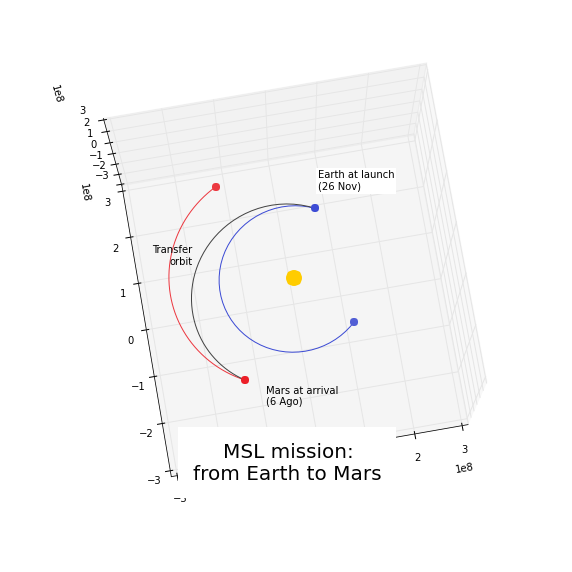

In [12]:
ax.view_init(80, 260)
fig